In [2]:
from matplotlib import pyplot
import pandas as pd
import numpy as np
from scipy.stats import mode

def mode_function(df):
    counts = mode(df)
    return counts[0][0]

feature_data=pd.read_csv('raw/feature_data_2017_2222.csv',dtype={"link_ID":str})


'''
train data 4月训练
'''
train = pd.DataFrame()
train4 = pd.DataFrame()
for curHour in [8,15,18]:
	print("train4 curHour", curHour)
	trainTmp = feature_data.loc[(feature_data.time_interval_month == 4)&
		   (feature_data.time_interval_begin_hour==curHour)
		  # &(feature_data.time_interval_day<=15)
		   ,:]

	for i in [58,48,38,28,18,0]:
		tmp = feature_data.loc[(feature_data.time_interval_month == 4)&
				(feature_data.time_interval_begin_hour==curHour-1)
										&(feature_data.time_interval_minutes >= i),:]
		tmp = tmp.groupby(['link_ID', 'time_interval_day'])[
				'travel_time'].agg([('mean_%d' % (i), np.mean), ('median_%d' % (i), np.median),
									('mode_%d' % (i), mode_function)]).reset_index()
		#train = pd.merge(train,tmp,on=['link_ID','time_interval_day','time_interval_begin_hour'],how='left')
		trainTmp = pd.merge(trainTmp,tmp,on=['link_ID','time_interval_day'],how='left')
		
	train4 = pd.concat([train4,trainTmp], axis=0)
	print("     train4.shape", train4.shape)

train4_history = feature_data.loc[(feature_data.time_interval_month == 3),: ]
train4_history = train4_history.groupby(['link_ID', 'time_interval_minutes'])[
			'travel_time'].agg([('mean_m', np.mean), ('median_m', np.median),
								('mode_m', mode_function)]).reset_index()

train4 = pd.merge(train4,train4_history,on=['link_ID','time_interval_minutes'],how='left')

train_history2 = feature_data.loc[(feature_data.time_interval_month == 3),: ]
train_history2 = train_history2.groupby(['link_ID', 'time_interval_begin_hour'])[
			'travel_time'].agg([ ('median_h', np.median),
								('mode_h', mode_function)]).reset_index()
			
train4 = pd.merge(train4, train_history2,on=['link_ID','time_interval_begin_hour'],how='left')
print("train4.shape", train4.shape)
train = train4

train_label = np.log1p(train.pop('travel_time'))
train_time = train.pop('time_interval_begin')

train.drop(['time_interval_month'],inplace=True,axis=1)
train_link=train.pop('link_ID') #(253001, 35)
print("train.shape", train.shape)

'''
test   评测6月整月    
'''

test = pd.DataFrame()
for curHour in [8,15,18]:
	print("test curHour", curHour)
	testTmp = feature_data.loc[(feature_data.time_interval_month == 5)&
		   (feature_data.time_interval_begin_hour==curHour)
		   ,:]

	for i in [58,48,38,28,18,0]:
		tmp = feature_data.loc[(feature_data.time_interval_month == 5)&
				(feature_data.time_interval_begin_hour==curHour-1)
										&(feature_data.time_interval_minutes >= i),:]
		tmp = tmp.groupby(['link_ID', 'time_interval_day'])[
				'travel_time'].agg([('mean_%d' % (i), np.mean), ('median_%d' % (i), np.median),
									('mode_%d' % (i), mode_function)]).reset_index()
		testTmp = pd.merge(testTmp,tmp,on=['link_ID','time_interval_day'],how='left')
	
	test = pd.concat([test,testTmp], axis=0)
	print("test.shape", test.shape)

test_history = feature_data.loc[(feature_data.time_interval_month == 4),: ]
test_history = test_history.groupby(['link_ID', 'time_interval_minutes'])[
			'travel_time'].agg([('mean_m', np.mean), ('median_m', np.median),
								('mode_m', mode_function)]).reset_index()

test = pd.merge(test,test_history,on=['link_ID','time_interval_minutes'],how='left')

test_history2 = feature_data.loc[(feature_data.time_interval_month == 4),: ]
test_history2 = test_history2.groupby(['link_ID', 'time_interval_begin_hour'])[
			'travel_time'].agg([ ('median_h', np.median),
								('mode_h', mode_function)]).reset_index()
			
test = pd.merge(test,test_history2,on=['link_ID','time_interval_begin_hour'],how='left')

test_label = np.log1p(test.pop('travel_time'))
test_time = test.pop('time_interval_begin')


test.drop(['time_interval_month'],inplace=True,axis=1)

#去掉link_ID
test_link=test.pop('link_ID')

#填补缺省值
train = train.fillna(0)
test  = test.fillna(0)

def mape_ln(y,d):
    c=d.get_label()
    result= -np.sum(np.abs(np.expm1(y)-np.abs(np.expm1(c)))/np.abs(np.expm1(c)))/len(c)
    return "mape",result
#其中y为预测值，d为真实值

def mape_object(d,y):
    # print(d)
    # print(y)
    grad=1.0*(y-d)/d
    hess=1.0/d
    return grad,hess


def mape_ln_gbm(d,y):
    # c=d.get_label()
    result=np.sum(np.abs(np.expm1(y)-np.abs(np.expm1(d)))/np.abs(np.expm1(d)))/len(d)
    return "mape",result,False

def feature_vis(regressor, train_feature):
    importances = regressor.feature_importances_
    indices = np.argsort(importances)[::-1]
    selected_features = [train_feature[e] for e in indices]
    plt.figure(figsize=(20, 10))
    plt.title("train_feature importances")
    plt.bar(range(len(train_feature)), importances[indices],align="center")
    plt.xticks(range(len(selected_features)), selected_features, rotation=70)
    plt.show()
	
import xgboost as xgb
xlf = xgb.XGBRegressor(max_depth=8,
                       learning_rate=0.01,
                       n_estimators=1000,
                       silent=True,
                       objective=mape_object,
                       #objective='reg:linear',
                       nthread=-1,
                       gamma=0,
                       min_child_weight=6,
                       max_delta_step=0,
                       subsample=0.9,
                       colsample_bytree=0.8,
                       colsample_bylevel=1,
                       reg_alpha=1e0,
                       reg_lambda=0,
                       scale_pos_weight=1,
                       seed=9,
                       missing=None)

xlf.fit(train.values, train_label.values, eval_metric=mape_ln, 
        verbose=True, eval_set=[(test.values, test_label.values)],
        early_stopping_rounds=10)

train4 curHour 8
     train4.shape (110200, 65)
train4 curHour 15
     train4.shape (222250, 65)
train4 curHour 18
     train4.shape (336549, 65)
train4.shape (336549, 70)
train.shape (336549, 66)
test curHour 8
test.shape (115512, 65)
test curHour 15
test.shape (234638, 65)
test curHour 18
test.shape (354134, 65)
[0]	validation_0-rmse:2.19743	validation_0-mape:-0.88616
Multiple eval metrics have been passed: 'validation_0-mape' will be used for early stopping.

Will train until validation_0-mape hasn't improved in 10 rounds.
[1]	validation_0-rmse:2.177	validation_0-mape:-0.883024
[2]	validation_0-rmse:2.15677	validation_0-mape:-0.879881
[3]	validation_0-rmse:2.13671	validation_0-mape:-0.876717
[4]	validation_0-rmse:2.11691	validation_0-mape:-0.873533
[5]	validation_0-rmse:2.09728	validation_0-mape:-0.870329
[6]	validation_0-rmse:2.07784	validation_0-mape:-0.867112
[7]	validation_0-rmse:2.05861	validation_0-mape:-0.863871
[8]	validation_0-rmse:2.03952	validation_0-mape:-0.860603
[9]	va

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, importance_type='gain',
       learning_rate=0.01, max_delta_step=0, max_depth=8,
       min_child_weight=6, missing=None, n_estimators=1000, n_jobs=1,
       nthread=-1, objective=<function mape_object at 0x0000000CF640DBF8>,
       random_state=0, reg_alpha=1.0, reg_lambda=0, scale_pos_weight=1,
       seed=9, silent=True, subsample=0.9)

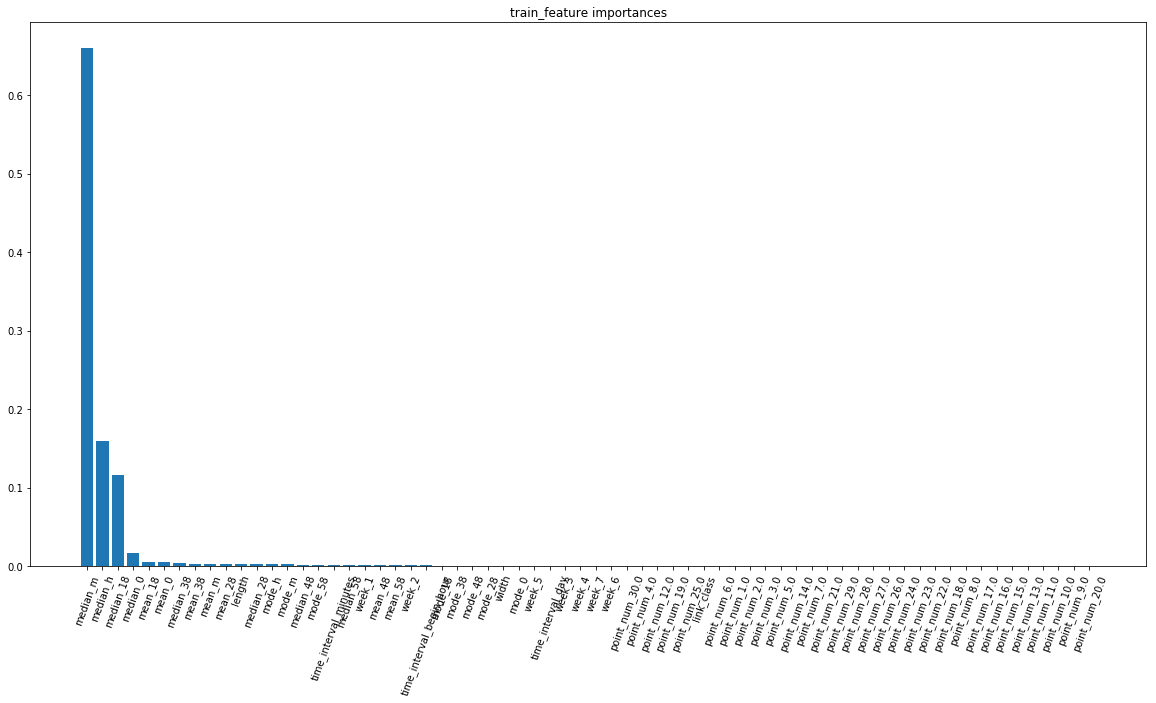

In [3]:
import matplotlib.pyplot as plt

def featureVis(regressor, train_feature):
    importances = regressor.feature_importances_
    indices = np.argsort(importances)[::-1]
    selected_features = [train_feature[e] for e in indices]
    plt.figure(figsize=(20, 10))
    plt.title("train_feature importances")
    plt.bar(range(len(train_feature)), importances[indices],align="center")
    plt.xticks(range(len(selected_features)), selected_features, rotation=70)
    plt.show()

train_feature = train.columns.values.tolist()
featureVis(xlf,train_feature)
